## Determine a Restaurant's Success
### By way of getting 5-star rating on Yelp
>#### Mohammad Ashrafuzzaman

>STAT 504: Analytics

>December 16, 2015


### Abstract:
> The goal of this task is to predict a restaurant’s overall
star rating based on how many reviews are written on the restaurant, how many stars a restaurant is given by a patron, how many stars a patron has got, and how many reviews a patron has written on the Yelp page. We belief that all these factors influence positively towards garnering higher star rating.

> Feature Variables:      
 3. 'business_review_count',        
 5. 'review_stars',                     
 6. 'user_average_stars',     
 7. 'user_review_count',                   
 8. 'tip_likes'
 
>Response Variable:
 1. 'business_stars',



### Data:


For this project, we shall be using publicly-available datasets from the Yelp Dataset Challenge.
>Data Source: http://www.yelp.com/dataset_challenge

Yelp provides detailed service connecting patrons to most relevant local businesses based on preferences and constraints. Yelp search engine has sift through over 61 million reviews by patrons and developed this dataset that is deep, rich and entirely from the real-life.
        
#### The Challenge Dataset:

1.6M reviews and 500K tips by 366K users for 61K businesses
481K business attributes, e.g., hours, parking availability, ambience.
Social network of 366K users for a total of 2.9M social edges.
Aggregated check-ins over time for each of the 61K businesses

There are 5 tables in the dataset:
 1. Business (42,153 records)
 2. Review (1,125,458 records)
 3. Check ins (31,617 records)
 4. Tips (403,210 records)
 5. Users (252,898 records)

We are not using the Check ins tables in this analysis
#### Data cleaning:

1. Filter out other columns not useful
3. We need only restaurant data


### Data Description (i.e., the Schema)

#### Here are the Definitions of the Tables with their Attributes:


##### business
 {
    'type': 'business', 
    'business_id': (encrypted business id),
    'name': (business name),
    'neighborhoods': [(hood names)],
    'full_address': (localized address),
    'city': (city),
    'state': (state),
    'latitude': latitude,
    'longitude': longitude,
    'stars': (star rating, rounded to half-stars),
    'review_count': review count,
    'categories': [(localized category names)]
    'open': True / False (corresponds to closed, not business hours),
    'hours': {
        (day_of_week): {
            'open': (HH:MM),
            'close': (HH:MM)
        },
        ...
    },
    'attributes': {
        (attribute_name): (attribute_value),
        ...
    },
}

##### review
{
    'type': 'review',
    'business_id': (encrypted business id),
    'user_id': (encrypted user id),
    'stars': (star rating, rounded to half-stars),
    'text': (review text),
    'date': (date, formatted like '2012-03-14'),
    'votes': {(vote type): (count)},
}

##### user
{
    'type': 'user',
    'user_id': (encrypted user id),
    'name': (first name),
    'review_count': (review count),
    'average_stars': (floating point average, like 4.31),
    'votes': {(vote type): (count)},
    'friends': [(friend user_ids)],
    'elite': [(years_elite)],
    'yelping_since': (date, formatted like '2012-03'),
    'compliments': {
        (compliment_type): (num_compliments_of_this_type),
        ...
    },
    'fans': (num_fans),
}

##### check-in
{
    'type': 'checkin',
    'business_id': (encrypted business id),
    'checkin_info': {
        '0-0': (number of checkins from 00:00 to 01:00 on all Sundays),
        '1-0': (number of checkins from 01:00 to 02:00 on all Sundays),
        ...
        '14-4': (number of checkins from 14:00 to 15:00 on all Thursdays),
        ...
        '23-6': (number of checkins from 23:00 to 00:00 on all Saturdays)
    }, # if there was no checkin for a hour-day block it will not be in the dict
}

##### tip
{
    'type': 'tip',
    'text': (tip text),
    'business_id': (encrypted business id),
    'user_id': (encrypted user id),
    'date': (date, formatted like '2012-03-14'),
    'likes': (count),
}


In [7]:
import matplotlib
%matplotlib nbagg
import matplotlib.pyplot as plt
from ggplot import *

from pprint import pprint
import pyparser
import pyparsing
from pandas import DataFrame
import pandas as pd
import numpy as np
import seaborn as sns
import pydot
import pylab
import scipy.sparse as sp
import os
import urllib2
import csv
import urllib
import math
import time
import json
from pandas.io.json import json_normalize
from math import log
from math import exp
import pylab
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.externals.six import StringIO  
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import KFold
from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, SelectFpr, chi2
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from IPython.display import Image

#pd.options.display.max_colwidth=1000
print pd.__version__
print matplotlib.__version__


0.17.1
1.5.0


### Data Source
>The URL of the dataset is given below. I have already downloaded the dataset to my hard-disk as the dataset is quite large and takes some time to download.

In [ ]:
URL_YELP_DATASET_CHALLENGE = 'http://www.yelp.com/dataset_challenge'

### Data Wrangling 

We need to clean the given files to be interpretable by Panda's JSON function: 
- Add a comma after every line of each file
- Remove the last comma of each file
- Prepend '[' as the first character of each file
- Append ']' as the last character of each file


In [8]:
MY_YELP_JSON_RAW_DATA_DIR = 'YELP_DATASETS'
MY_YELP_JSON_CLEAN_DATA_DIR = 'YELP_DATASETS/Cleaned_Dataset'
MY_YELP_CSV_DATA_DIR = MY_YELP_JSON_CLEAN_DATA_DIR

In [ ]:
!mkdir -p $MY_YELP_JSON_CLEAN_DATA_DIR
!mkdir -p $MY_YELP_CSV_DATA_DIR
!echo MY_YELP_JSON_RAW_DATA_DIR : $MY_YELP_JSON_RAW_DATA_DIR
!ls -sh $MY_YELP_JSON_RAW_DATA_DIR
!echo
!echo MY_YELP_JSON_CLEAN_DATA_DIR : $MY_YELP_JSON_CLEAN_DATA_DIR
!ls -sh $MY_YELP_JSON_CLEAN_DATA_DIR
!echo
!echo MY_YELP_CSV_DATA_DIR : $MY_YELP_CSV_DATA_DIR
!ls -sh $MY_YELP_CSV_DATA_DIR

The Review datafile with 1125458 reviews is a big file (over 1GB). This is being split in 4 smaller files of about same size.

In [ ]:
!head -562729 $MY_YELP_JSON_RAW_DATA_DIR/'yelp_academic_dataset_review.json'  > $MY_YELP_JSON_RAW_DATA_DIR/'yelp_academic_dataset_review_p1.json'
!tail -281365 $MY_YELP_JSON_RAW_DATA_DIR/'yelp_academic_dataset_review_p1.json'  > $MY_YELP_JSON_RAW_DATA_DIR/'yelp_academic_dataset_review_p2.json'
!head -281364 $MY_YELP_JSON_RAW_DATA_DIR/'yelp_academic_dataset_review.json' > $MY_YELP_JSON_RAW_DATA_DIR/'yelp_academic_dataset_review_p1.json'

!tail -562729 $MY_YELP_JSON_RAW_DATA_DIR/'yelp_academic_dataset_review.json'  > $MY_YELP_JSON_RAW_DATA_DIR/'yelp_academic_dataset_review_p3.json'
!head -281364 $MY_YELP_JSON_RAW_DATA_DIR/'yelp_academic_dataset_review_p3.json'  > $MY_YELP_JSON_RAW_DATA_DIR/'yelp_academic_dataset_review_p4.json'
!tail -281365 $MY_YELP_JSON_RAW_DATA_DIR/'yelp_academic_dataset_review.json'  > $MY_YELP_JSON_RAW_DATA_DIR/'yelp_academic_dataset_review_p3.json'

#### Loading the content of file yelp_academic_dataset_business.json into pandas DataFrame business_DF
>We also rename some column names to make them distinct from same named columns in other files.
>We also delete columns that we are not going to use for this analysis


In [9]:
# read the entire file into a python array
start = time.time()
json_filename = os.path.join(MY_YELP_JSON_RAW_DATA_DIR, 'yelp_academic_dataset_business.json')
with open(json_filename, 'rb') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object. Cconvert it into an *array* of 
# JSON objects which, in and of itself, is one large JSON object
# Add square brackets to the beginning and end, and have all the 
# individual business JSON objects separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas dataframe
business_DF = pd.read_json(data_json_str)
business_DF.rename(columns={ 'review_count': 'business_review_count', 'stars': 'business_stars'}, inplace=True)
# We don't need all the columns for our analysis. So drop the ones not needed
business_DF.drop(['neighborhoods','full_address', 'hours','latitude', 'longitude'], axis=1, inplace=True)
business_DF.drop(['open','type','attributes', 'state', 'name'], axis=1, inplace=True)
# replace missing values with nan's
business_DF=business_DF.replace(' ', np.NaN)
# drop nan's
business_DF=business_DF.dropna()
end = time.time()
print "Time: ", (end-start)
print business_DF.shape


Time:  2.73847603798
(61184, 5)


#### Filtering out all the rows that are not 'Restaurant' and removing all other rows from business_DF
>After this we are left with 21892 (Restaurants) records down from original 61184 total records in business_DF.

In [10]:
def nested_contains(lst, obj):
    return any(item == obj or
               isinstance(item, list) and nested_contains(item, obj)
               for item in lst)

rowlist = []
for i in business_DF.index:
    if(nested_contains(business_DF.ix[i].categories, 'Restaurants')):
        rowlist.append(business_DF.ix[i])
        
business_DF = pd.DataFrame(rowlist)  
print business_DF.shape

(21892, 5)


Now that only Restaurants are picked, we do not need 'categories' column anymore

In [11]:
business_DF.drop(['categories'], axis=1, inplace=True)

#### Loading the content of other files into pandas DataFrames
>We also rename some column names to make them distinct from same named columns in other files.
>We also delete columns that we are not going to use for this analysis


In [12]:
start = time.time()
json_filename = os.path.join(MY_YELP_JSON_RAW_DATA_DIR, 'yelp_academic_dataset_user.json')
with open(json_filename, 'rb') as f:
    data = f.readlines()
data = map(lambda x: x.rstrip(), data)
data_json_str = "[" + ','.join(data) + "]"
user_DF = pd.read_json(data_json_str)
user_DF.rename(columns={'review_count': 'user_review_count', 'stars': 'user_stars', 'average_stars': 'user_average_stars'}, inplace=True)
user_DF.drop(['friends','type', 'fans', 'name', 'compliments'], axis=1, inplace=True)
user_DF.drop(['yelping_since', 'elite','votes'], axis=1, inplace=True)
end = time.time()
print "Time: ", (end-start)
print user_DF.shape

Time:  10.1244029999
(366715, 3)


In [13]:
start = time.time()
json_filename = os.path.join(MY_YELP_JSON_RAW_DATA_DIR, 'yelp_academic_dataset_review.json')
with open(json_filename, 'rb') as f:
    data = f.readlines()
data = map(lambda x: x.rstrip(), data)
data_json_str = "[" + ','.join(data) + "]"
review_DF = pd.read_json(data_json_str)
review_DF.rename(columns={'stars': 'review_stars'}, inplace=True)
review_DF.drop(['type','review_id', 'text', 'date','votes'], axis=1, inplace=True)
end = time.time()
print "Time: ", (end-start)
print review_DF.shape


# There is no way to trim down the review file by 'Restaurants' only before we do the JOIN. Otherwise we could have 
# saved some  more computation time.

Time:  53.7042880058
(1569264, 3)


In [14]:
start = time.time()
json_filename = os.path.join(MY_YELP_JSON_RAW_DATA_DIR, 'yelp_academic_dataset_tip.json')
with open(json_filename, 'rb') as f:
    data = f.readlines()
data = map(lambda x: x.rstrip(), data)
data_json_str = "[" + ','.join(data) + "]"
tip_DF = pd.read_json(data_json_str)
tip_DF.rename(columns={'likes': 'tip_likes'}, inplace=True)
tip_DF.drop(['type', 'text', 'date'], axis=1, inplace=True)
end = time.time()
print "Time: ", (end-start)
print tip_DF.shape


Time:  6.196352005
(495107, 3)


#### Now we join the 3 DataFrames into one using merge method. This is similar to JOIN in relational database langauge SQL.

##### Inner joins
>Inner join is the most common type of join. An inner join combines two DataFrames based on a join key and returns a new DataFrame that contains only those rows that have matching values in both of the original DataFrames.

>Inner joins yield a DataFrame that contains only rows where the value being joins exists in BOTH tables. 


In [15]:
start = time.time()
business_and_review_DF = pd.merge(business_DF, review_DF, on='business_id', how='inner')
business_and_user_and_review_DF = pd.merge(business_and_review_DF, user_DF, on ='user_id', how='inner')
end = time.time()
print "Time: ", (end-start)
business_and_review_DF.shape


Time:  1.51487112045


(990627, 6)

In [16]:
business_and_user_and_review_DF.shape

(990627, 8)

In [29]:
start = time.time()
TURBO_DF = pd.merge(business_and_user_and_review_DF, tip_DF, on=['user_id', 'business_id'], how='inner')
end = time.time()
print "Time: ", (end-start)
TURBO_DF.head()

Time:  0.821218967438


,business_id,city,business_review_count,business_stars,review_stars,user_id,user_average_stars,user_review_count,tip_likes
0,nqRNOug4OMrYTTZg-qLxXA,Swissvale,5,4.0,5,8fApIAMHn2MZJFUiCQto5Q,3.40,34,0
1,htwLFap6Oe-k-Gj2xTnjiA,Pittsburgh,35,3.5,4,8fApIAMHn2MZJFUiCQto5Q,3.40,34,0
2,IS9ZqBV6R0olC_OYv-vGjQ,Pittsburgh,4,4.0,4,4-3IU5uUH90m21TWbZhhnA,3.87,50,0
3,eznh0XjVtv924K-KYx_ilQ,Homestead,13,3.0,4,T_wjLgPOPXry7Bea4MzoVQ,3.11,786,0
4,r8jeeS3k_diihMDSu9IjlA,Pittsburgh,108,4.0,4,T_wjLgPOPXry7Bea4MzoVQ,3.11,786,0


In [25]:
TURBO_DF.shape

(130721, 9)

#### Delete Python variables that will not be needed any more. This will free up memories occupied by these variables.

In [ ]:
start = time.time()
%reset_selective business_and_user_and_review_DF
%reset_selective business_DF
%reset_selective user_DF
%reset_selective review_DF
%reset_selective tip_DF
end = time.time()
print "Time: ", (end-start)

#### Now save this concatenated DF to a file. So that if we need later we can just load it without needing to do all the Preprocessing

In [ ]:
start = time.time()
TURBO_csv_filename = os.path.join(MY_YELP_CSV_DATA_DIR, 'TURBO_df.csv')

if not os.path.isfile(TURBO_csv_filename):
    TURBO_DF.to_csv(TURBO_csv_filename, index=False, encoding='utf-8')
else:
    TURBO_DF = pd.read_csv(TURBO_csv_filename)
    
!ls -sh $TURBO_csv_filename
end = time.time()
print "Time: ", (end-start)

### Data Visualization
>Some graphical and non-graphical visualization of the filtered, cleaned and massaged dataset that we are going to use for the analysis.

<IPython.core.display.Javascript object>


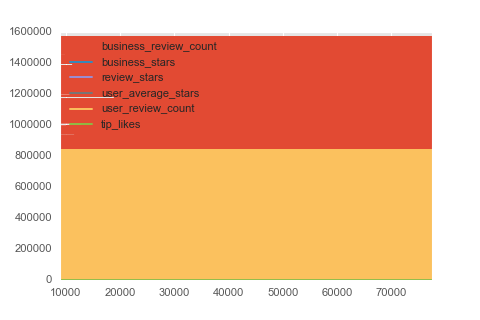

In [90]:
import matplotlib
%matplotlib nbagg
matplotlib.style.use('ggplot')

TURBO_DF_cs = TURBO_DF.cumsum()
TURBO_DF_cs.plot();

In [19]:
print TURBO_DF.columns

Index([          u'business_id',                  u'city',
       u'business_review_count',        u'business_stars',
                u'review_stars',               u'user_id',
          u'user_average_stars',     u'user_review_count',
                   u'tip_likes'],
      dtype='object')


In [20]:
print TURBO_DF.describe().transpose()

                        count        mean         std  min    25%     50%  \
business_review_count  130721  316.781963  568.859166    3  57.00  139.00   
business_stars         130721    3.754030    0.527284    1   3.50    4.00   
review_stars           130721    4.106341    1.093610    1   4.00    4.00   
user_average_stars     130721    3.868024    0.534235    1   3.62    3.87   
user_review_count      130721  163.673893  276.941663    1  16.00   63.00   
tip_likes              130721    0.016531    0.143325    0   0.00    0.00   

                          75%   max  
business_review_count  324.00  4578  
business_stars           4.00     5  
review_stars             5.00     5  
user_average_stars       4.14     5  
user_review_count      192.00  4573  
tip_likes                0.00     5  


In [21]:
TURBO_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130721 entries, 0 to 130720
Data columns (total 9 columns):
business_id              130721 non-null object
city                     130721 non-null object
business_review_count    130721 non-null int64
business_stars           130721 non-null float64
review_stars             130721 non-null int64
user_id                  130721 non-null object
user_average_stars       130721 non-null float64
user_review_count        130721 non-null int64
tip_likes                130721 non-null int64
dtypes: float64(2), int64(4), object(3)
memory usage: 10.0+ MB


### Sampling of Data

>More data can result in much longer running times for algorithms and larger computational and memory requirements. So we take a smaller representative sample of the selected data that may be much faster for exploring and prototyping solutions before considering the whole dataset.

>Our sample size is 5000 which about 5% of the total dataset of size 130721. This is right about the suitable size for running the analysis on an average personal computer.

In [30]:
TURBO_DF = TURBO_DF.sample(n=5000)
TURBO_DF.shape

(5000, 9)

##### Splitting into Training and Test Dataset

We split the sampled TURBO datase randomly so that 75% of the total dataset will become training dataset, and 25% will become test dataset, respectively.

Feature columns are all columns except the Response column

In [31]:
TURBO_DF['business_stars'] = np.where(TURBO_DF['business_stars'] > 3.6, 1, 0)
num5 = len(TURBO_DF.business_stars[(TURBO_DF.business_stars == 1)])
num1= len(TURBO_DF.business_stars[(TURBO_DF.business_stars == 0)])
print "Number of rows with 'business_stars' > 3.4 = ", num5
print "Number of rows with 'business_stars' < 3.4 = ", num1

Number of rows with 'business_stars' > 3.4 =  2847
Number of rows with 'business_stars' < 3.4 =  2153


In [79]:
feature_cols = ['business_review_count', 'review_stars','user_average_stars','user_review_count', 'tip_likes']
X = TURBO_DF[feature_cols]
y = TURBO_DF.business_stars.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234567)

In [34]:
start = time.time()
rforest = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rforest.fit(X_train, y_train)
end = time.time()
print "Time: ", (end-start)

Time:  0.424986124039


<IPython.core.display.Javascript object>


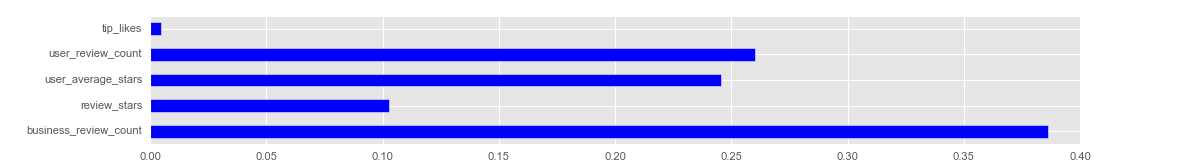

In [36]:
import matplotlib
%matplotlib nbagg
matplotlib.style.use('ggplot')

feature_importances = pd.Series(rforest.feature_importances_, index=X.columns)
feature_importances.plot(kind="barh", figsize=(15,2))

<IPython.core.display.Javascript object>


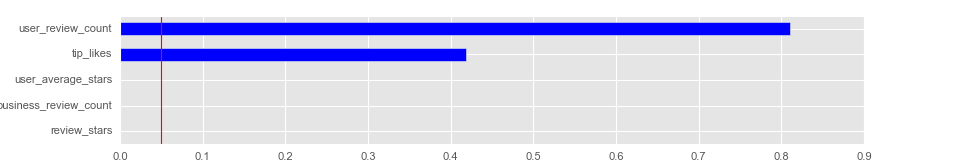

In [37]:
import matplotlib
%matplotlib nbagg
matplotlib.style.use('ggplot')

topfeatures = SelectKBest(chi2, k=all)
topfeatures = SelectFpr(chi2, alpha=0.05)

x_indices = np.arange(X.shape[-1])

selector = SelectFpr(f_classif, alpha=0.05)
selector.fit(X_train, y_train)

topindex = pd.Series(selector.pvalues_, index=X.columns)
topindex.sort_values(inplace=True)
topindex.plot(kind="barh", figsize=(12,2));
plt.axvline(x=0.05, ymin=0, ymax = 5, linewidth=1, color='red')
plt.title('Figure: Top Features')

## Models Evaluation:

### 1. Null Model
>Assuming every business gets 5 star


In [80]:
start = time.time()
y_pred_prob = nullmodel.predict_proba(X_test)[:, 1]
ypred = np.ones(5000)
null_score_roc = metrics.roc_auc_score(y, ypred)
null_score_acc=num5/(5000.0)

X = X_train
y = y_train
nullmodel = DummyClassifier(strategy='most_frequent', random_state=99, constant=None)
nullmodel.fit(X,y)
end = time.time()
time_1_null = end - start
print "Accuracy with Null Model: " + str(null_score_acc)
print "ROC AUC with Null Model: " + str(null_score_roc)
print "Time: ",time_1_null

Accuracy with Null Model: 0.5694
ROC AUC with Null Model: 0.5
Time:  0.00262999534607


### 2. Logistic Regression Model

In [39]:
start = time.time()
lreg = LogisticRegression(random_state = 22, C=1e9)
X = X_train
y = y_train
lreg.fit(X,y)
lreg_scores_acc = cross_val_score(lreg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
lreg_scores_roc = cross_val_score(lreg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
end = time.time()
time_1_logreg = end - start
print "Accuracy with Logistic Regression is: ", lreg_scores_acc
print "ROC AUC with Logistic Regression is :", lreg_scores_roc
print "Time = ", time_1_logreg

Accuracy with Logistic Regression is:  0.6736
ROC AUC with Logistic Regression is : 0.722522990388
Time =  0.294174909592


### 3. K Nearest-Neighbor Model

In [40]:
# Find an optimal value of K for KNN
k_range = range(1, 10)
k_scores_acc = []
k_scores_roc = []
X = X_train
y = y_train
start = time.time()
for k in k_range:
    knnopt = KNeighborsClassifier(n_neighbors=k)
    scores_acc = cross_val_score(knnopt, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    k_scores_acc.append(scores_acc.mean())
    scores_roc = cross_val_score(knnopt, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc')
    k_scores_roc.append(scores_roc.mean())
end = time.time()
print "k_scores_acc: ", k_scores_acc
print "k_scores_roc: ", k_scores_roc
print "Time: " + str(end - start)

k_scores_acc:  [0.62133333333333329, 0.5901333333333334, 0.64106666666666678, 0.61413333333333342, 0.62586666666666668, 0.61919999999999997, 0.62319999999999998, 0.62186666666666668, 0.62213333333333332]
k_scores_roc:  [0.61077277696246557, 0.63848006404244262, 0.66239587524406784, 0.66059517028423109, 0.66272556256186788, 0.66938698197793411, 0.66913375770031569, 0.66819794640564578, 0.66773817817543091]
Time: 1.26059412956


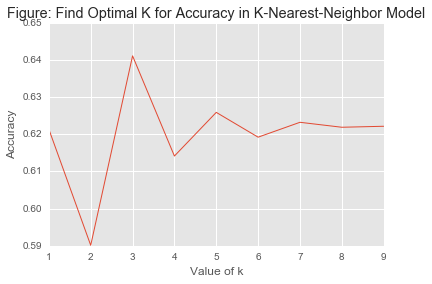

In [41]:
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

plt.plot(k_range, k_scores_acc, linewidth = 1.0)
plt.xlabel('Value of k')
plt.ylabel('Accuracy')
plt.title('Figure: Find Optimal K for Accuracy in K-Nearest-Neighbor Model')

<IPython.core.display.Javascript object>


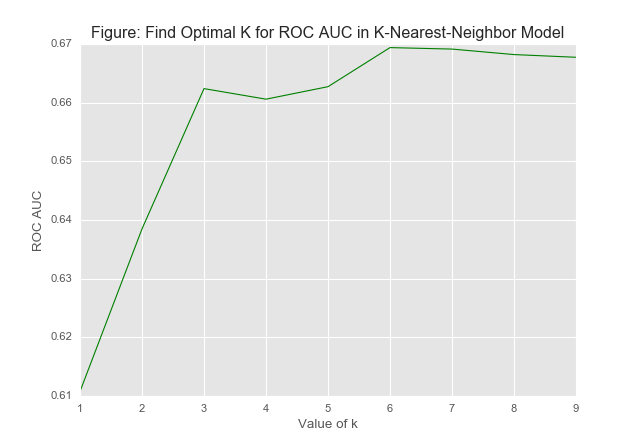

In [42]:
import matplotlib
%matplotlib nbagg
matplotlib.style.use('ggplot')

plt.plot(k_range, k_scores_roc, color = 'green', linewidth = 1)
plt.xlabel('Value of k')
plt.ylabel('ROC AUC')
plt.title('Figure: Find Optimal K for ROC AUC in K-Nearest-Neighbor Model')

Looks like the optimal value of k is 3 for  Accuracy and 6 for ROC AUC.

#### Re-run K Nearest-Neighbor Model with k=3 and k=6

In [43]:
start = time.time()
X = X_train
y = y_train
knn = KNeighborsClassifier(n_neighbors=3)
knn_scores_acc = cross_val_score(knn, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
knn = KNeighborsClassifier(n_neighbors=6)
knn_scores_roc = cross_val_score(knn, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
end = time.time()
time_1_knn = end - start
print "Accuracy with kNN with k=99: ", knn_scores_acc
print "Accuracy with kNN with k=99: ", knn_scores_roc
print "Time: " + str(time_1_knn)


Accuracy with kNN with k=99:  0.633066666667
Accuracy with kNN with k=99:  0.668145918373
Time: 0.168142080307


### 4. Naive-Bayes - Multinomial Model

In [44]:
start = time.time()
X = X_train
y = y_train
nbm = MultinomialNB()
nbm.fit(X, y)
nbm_pred_rating=nbm.predict(X_test)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
nbm_scores_acc = cross_val_score(nbm, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
nbm_scores_roc = cross_val_score(nbm, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
end = time.time()
time_1_nbm = end - start
print "Accuracy with Naive-Bayes - Multinomial Model: ", nbm_scores_acc
print "ROC AUC with Naive-Bayes - Multinomial Model: ", nbm_scores_roc
print "Time: ", time_1_nbm


Accuracy with Naive-Bayes - Multinomial Model:  0.600266666667
ROC AUC with Naive-Bayes - Multinomial Model:  0.616850637376
Time:  0.12703204155


### 5. Naive-Bayes - Gaussian Model

In [45]:
start = time.time()
X = X_train
y = y_train
nbg = GaussianNB()
nbg.fit(X, y)
nbg_pred_rating=nbm.predict(X_test)
GaussianNB()
nbg_scores_acc = cross_val_score(nbg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
nbg_scores_roc = cross_val_score(nbg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
end = time.time()
time_1_nbg = end - start
print "Accuracy with Naive-Bayes - Gaussian Model: ", nbg_scores_acc
print "ROC AUC with Naive-Bayes - Gaussian Model: ", nbg_scores_roc
print "Time: ",  time_1_nbg


Accuracy with Naive-Bayes - Gaussian Model:  0.650666666667
ROC AUC with Naive-Bayes - Gaussian Model:  0.696393996156
Time:  0.117505073547


### 6. Naive-Bayes - Bernoulli Model

In [46]:
start = time.time()
X = X_train
y = y_train
nbb = BernoulliNB()
nbb.fit(X, y)
nbb_pred_rating=nbm.predict(X_test)
BernoulliNB(alpha=1.0, class_prior=None, fit_prior=True)
nbb_scores_acc = cross_val_score(nbb, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
nbb_scores_roc = cross_val_score(nbb, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
end = time.time()
time_1_nbb = end - start
print "Accuracy with Naive-Bayes - Gaussian Model: ", nbb_scores_acc
print "ROC AUC with Naive-Bayes - Gaussian Model: ", nbb_scores_roc
print "Time: ",  time_1_nbb

Accuracy with Naive-Bayes - Gaussian Model:  0.572
ROC AUC with Naive-Bayes - Gaussian Model:  0.501350454765
Time:  0.125803947449


<IPython.core.display.Javascript object>


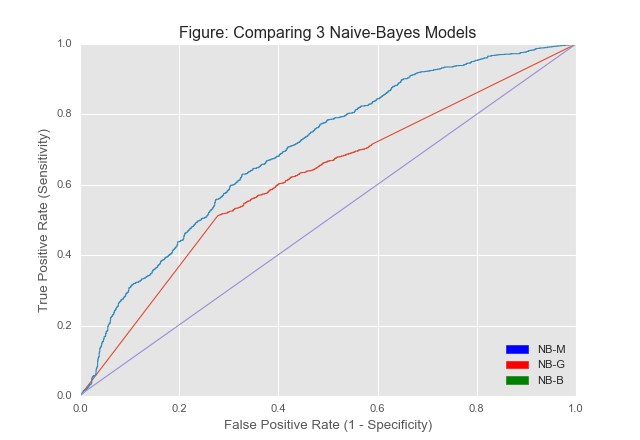

In [49]:
import matplotlib
%matplotlib nbagg
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

nbm_preds = nbm.predict_proba(X)[:,1]
nbm_fpr, nbm_tpr, _ = metrics.roc_curve(y, nbm_preds)

nbg_preds = nbg.predict_proba(X)[:,1]
nbg_fpr, nbg_tpr, _ = metrics.roc_curve(y, nbg_preds)

nbb_preds = nbb.predict_proba(X)[:,1]
nbb_fpr, nbb_tpr, _ = metrics.roc_curve(y, nbb_preds)

plt.plot(nbm_fpr, nbm_tpr, nbg_fpr, nbg_tpr, nbb_fpr, nbb_tpr, linewidth = 1.0)
blue_patch = mpatches.Patch(color='blue', label='NB-M')  
red_patch= mpatches.Patch(color='red', label='NB-G' )  
green_patch= mpatches.Patch(color='green', label='NB-B')  
plt.legend(handles=[blue_patch, red_patch, green_patch], loc=4)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Figure: Comparing 3 Naive-Bayes Models')

### 7. SVM Polynomial Kernel Model
>Stopped execution after it was still running for 5 hours.
>For the same reason, did not attempt SVM Gaussian Kernel Model

In [ ]:
start = time.time()
X = X_train
y = y_train
svmpoly = svm.SVC(kernel='poly', gamma=2)
svmpoly.fit(X,y)
svmpoly_scores = cross_val_score(svmpoly, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
end = time.time()
print svmpoly_scores
print "Time: " + str(end-start)

In [ ]:
# search for an optimal gamma for SVM Polynomial Kernel Model
X = X_train
y = y_train
g_range = range(1, 10)
g_scores = []
start = time.time()
for k in g_range:
    knn = svm.SVC(kernel='poly', gamma=k)
    scores = cross_val_score(svmpoly, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    g_scores.append(scores.mean())
end = time.time()
print g_scores
print "Time: " + str(end-start)

In [ ]:
import matplotlib
%matplotlib nbagg
matplotlib.style.use('ggplot')

plt.plot(g_range, g_scores)
plt.xlabel('Gamma')
plt.ylabel('Accuracy')

In [ ]:
# SVM Polynomial with optimized gamma
start = time.time()
svmpoly = svm.SVC(kernel='poly', gamma=8)
svmpoly.fit(X,y)
svmpoly_acc = cross_val_score(svmpoly, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
svmpoly_roc = cross_val_score(svmpoly, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
end = time.time()
time_1_svmpoly = end - start
print "SVM Polynomial with optimized gamma (=8) for accuracy: " + str(svmpoly_acc)
print "SVM Polynomial with optimized gamma (=8) for ROC AUC: " + str(svmpoly_roc)
print "Time: " + str(time_1_svmpoly)

### 8. Decision Tree Classifier Model

In [48]:
# Find optimal depth for Decision Tree Classifier Model
start = time.time()
X = X_train
y = y_train
dtc_range = range(1, 10)
dtc_scores_acc = []
dtc_scores_roc = []
for k in dtc_range:
    dtc = DecisionTreeClassifier(random_state = 22, max_depth=k)
    dtc_scores_a = cross_val_score(dtc, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
    dtc_scores_acc.append(dtc_scores_a.mean())
    dtc_scores_r = cross_val_score(dtc, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
    dtc_scores_roc.append(dtc_scores_r.mean())
end = time.time()
print "Accuracy of Decision Tree Classifier Model : " + str(dtc_scores_acc)
print "ROC AUC of Decision Tree Classifier Model : " + str(dtc_scores_roc)
print "Time: " +str(end-start)

Accuracy of Decision Tree Classifier Model : [0.65839999999999999, 0.65866666666666662, 0.66053333333333331, 0.67973333333333341, 0.67120000000000002, 0.67253333333333332, 0.66826666666666656, 0.66373333333333329, 0.65493333333333337]
ROC AUC of Decision Tree Classifier Model : [0.62023416429644784, 0.67827935308058895, 0.71042380698951157, 0.73066765181181081, 0.71677648091243862, 0.72255981510625034, 0.71068274660670883, 0.70217048582426089, 0.68617845471714034]
Time: 1.36276292801


<IPython.core.display.Javascript object>


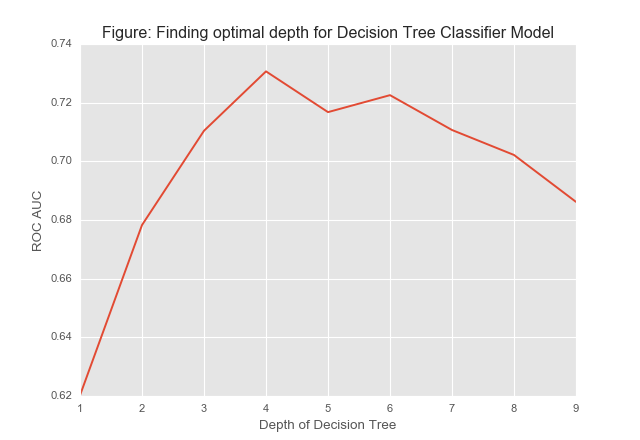

In [50]:
import matplotlib
%matplotlib nbagg
matplotlib.style.use('ggplot')

plt.plot(dtc_range, dtc_scores_roc)
plt.xlabel('Depth of Decision Tree')
plt.ylabel('ROC AUC')
plt.title('Figure: Finding optimal depth for Decision Tree Classifier Model')

#### Seems the best result happens at depth=4

In [51]:
start = time.time()
X = X_train
y = y_train
dtc = DecisionTreeClassifier(random_state = 22, max_depth=4)
dtc.fit(X,y)
dtc_scores_acc = cross_val_score(dtc, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
dtc_scores_auc = cross_val_score(dtc, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
end = time.time()
time_1_DTC_opt = end-start
print "Accuracy of Decision Tree Classifier Model with optimal depth (=3) : " + str(dtc_scores_acc)
print "ROC AUC of Decision Tree Classifier Model with optimal depth (=3) : " + str(dtc_scores_auc)
print "Time: " +str(time_1_DTC_opt)

Accuracy of Decision Tree Classifier Model with optimal depth (=3) : 0.676533333333
ROC AUC of Decision Tree Classifier Model with optimal depth (=3) : 0.72921250127
Time: 0.17036485672


### 10. Decision Tree Bagging Classification Method

In [92]:
# Find optimal depth for Bagging Decision Tree Classifier Model
start = time.time()
X = X_train
y = y_train
bag_scores_acc = []
bag_scores_roc = []
bag_range = range(1, 1000, 100)
for k in bag_range:
    bag_cl = BaggingClassifier(dtc, n_estimators=k, max_samples=1.0, max_features=5, bootstrap = False, bootstrap_features = True, random_state=1)
    bag_cl.fit(X, y)
    bag_scores_a = cross_val_score(bag_cl, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    bag_scores_r = cross_val_score(bag_cl, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc') 
    bag_scores_acc.append(bag_scores_a.mean())
    bag_scores_roc.append(bag_scores_r.mean())
end = time.time()

print bag_scores_acc
print bag_scores_roc
print "Time: " + str(end-start)

[0.64933333333333343, 0.67893333333333339, 0.68159999999999998, 0.68293333333333339, 0.68080000000000007, 0.68079999999999996, 0.68346666666666667, 0.68240000000000012, 0.68346666666666667, 0.68453333333333333]
[0.67134344644423938, 0.73904826034913518, 0.7362038070521042, 0.74008504379317519, 0.73503678066606037, 0.73944064430618028, 0.73871245321447598, 0.73850088832685368, 0.73841361263050631, 0.7384023242830049]
Time: 287.842110872


<IPython.core.display.Javascript object>


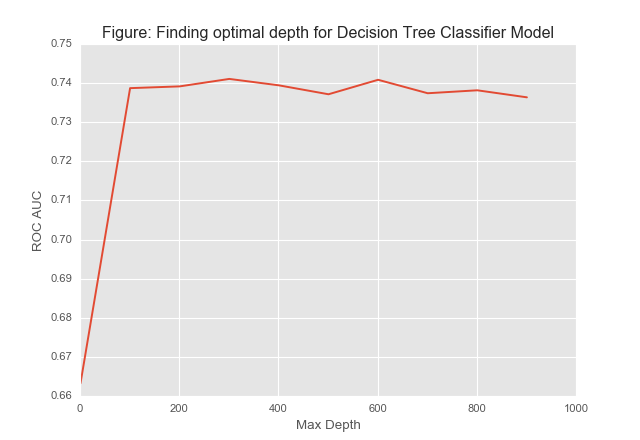

In [54]:
import matplotlib
%matplotlib nbagg
matplotlib.style.use('ggplot')

plt.plot(bag_range, bag_scores_roc)
plt.xlabel('Max Depth')
plt.ylabel('ROC AUC')
plt.title('Figure: Finding optimal depth for Decision Tree Classifier Model')

In [55]:
start = time.time()
bag = BaggingClassifier(max_samples = 1000, random_state = 22)
bag_cl = BaggingClassifier(bag, n_estimators=305, max_samples=1.0, bootstrap = False, bootstrap_features = True, random_state=42)
bag_cl.fit(X, y)
bag_scores_acc = cross_val_score(bag_cl, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
bag_scores_roc = cross_val_score(bag_cl, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean() 
end = time.time()
time_1_BagDTC_opt = end-start
print "Accuracy of Decision Tree Bagging Classification Method with optimal Estimator (=305) : " + str(bag_scores_acc)
print "ROC AUC of Decision Tree Bagging Classification Method with optimal Estimator (=305) : " + str(bag_scores_roc)
print "Time: " +str(time_1_BagDTC_opt)

Accuracy of Decision Tree Bagging Classification Method with optimal Estimator (=2) : 0.696533333333
ROC AUC of Decision Tree Bagging Classification Method with optimal Estimator (=2) : 0.761652684994
RMSE of Decision Tree Bagging Classification Method with optimal Estimator (=2) : -0.301066666667
Time: 274.382328987


### 11. Random Forest Model

In [56]:
start = time.time()
rf_results = []
leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
for min_samples in leaf_options:
    rf = RandomForestClassifier(n_estimators=100, 
                                  oob_score=True, 
                                  n_jobs=-1, 
                                  random_state=42, 
                                  max_features="auto", 
                                  min_samples_leaf=min_samples)
    rf.fit(X, y)
    roc = cross_val_score(rf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
    print str(min_samples) + ": C-stat: "+ str(roc)
    rf_results.append(roc)

end = time.time()
print "Time = " + str(end - start)


1: C-stat: 0.743085973122
2: C-stat: 0.742070388959
3: C-stat: 0.746501211835
4: C-stat: 0.745570747759
5: C-stat: 0.746374178095
6: C-stat: 0.747603831484
7: C-stat: 0.743609218743
8: C-stat: 0.745408434424
9: C-stat: 0.743496577897
10: C-stat: 0.745118428967
11: C-stat: 0.74284033089
12: C-stat: 0.744110877009
13: C-stat: 0.741031748176
14: C-stat: 0.745182541513
15: C-stat: 0.739958946563
16: C-stat: 0.74110990048
17: C-stat: 0.740367122188
18: C-stat: 0.744586710598
19: C-stat: 0.738059047081
20: C-stat: 0.742618797958
21: C-stat: 0.739408582049
22: C-stat: 0.741249698192
23: C-stat: 0.742541974054
24: C-stat: 0.740423809982
25: C-stat: 0.741468426472
Time = 90.6904120445


<IPython.core.display.Javascript object>


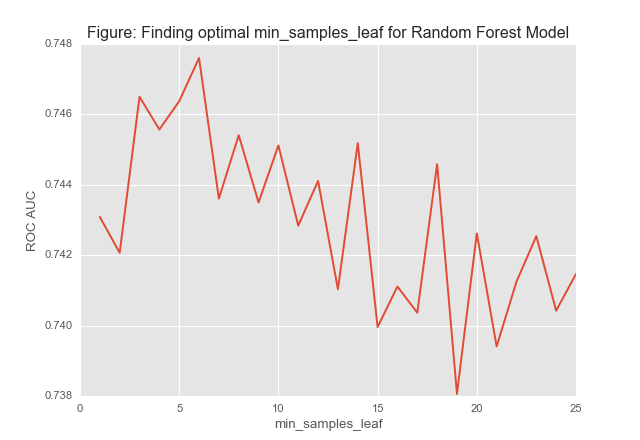

In [57]:
import matplotlib
%matplotlib nbagg
matplotlib.style.use('ggplot')

plt.plot(leaf_options, rf_results)
plt.xlabel('min_samples_leaf')
plt.ylabel('ROC AUC')
plt.title('Figure: Finding optimal min_samples_leaf for Random Forest Model')

In [60]:
# Find Optimal Depth 
start = time.time()
r_range = range(1, 50)
rf_scores_acc = []
rf_scores_roc = []

for k in r_range:
    rfc = RandomForestClassifier(max_depth=k)
    rf_scores_a = cross_val_score(rfc, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    rf_scores_acc.append(rf_scores_a.mean())
    rf_scores_r = cross_val_score(rfc, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc')
    rf_scores_roc.append(rf_scores_r.mean())
print rf_scores_acc
print rf_scores_roc
end = time.time()
print "Time = " + str(end - start)


[0.65920000000000001, 0.65999999999999992, 0.66879999999999995, 0.67706666666666659, 0.67706666666666671, 0.67999999999999994, 0.67946666666666666, 0.6850666666666666, 0.67200000000000004, 0.68079999999999996, 0.67386666666666672, 0.66960000000000008, 0.66586666666666672, 0.66159999999999997, 0.66373333333333329, 0.65626666666666666, 0.65200000000000002, 0.65866666666666673, 0.65546666666666664, 0.66080000000000005, 0.66720000000000002, 0.66400000000000003, 0.65813333333333335, 0.67120000000000002, 0.65680000000000005, 0.65226666666666655, 0.64826666666666666, 0.64106666666666656, 0.65706666666666658, 0.66213333333333324, 0.65466666666666662, 0.65866666666666673, 0.65146666666666664, 0.66453333333333331, 0.65893333333333337, 0.65493333333333337, 0.65600000000000003, 0.66799999999999993, 0.65413333333333346, 0.66479999999999995, 0.67093333333333338, 0.66559999999999997, 0.6624000000000001, 0.6458666666666667, 0.65413333333333334, 0.65893333333333337, 0.66000000000000003, 0.6559999999999

<IPython.core.display.Javascript object>


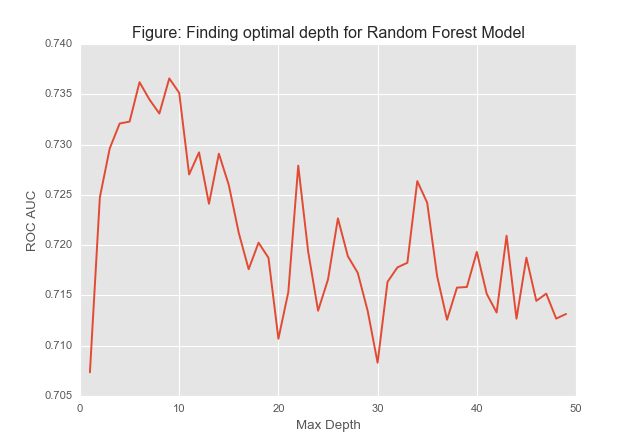

In [61]:
import matplotlib
%matplotlib nbagg
matplotlib.style.use('ggplot')

plt.plot(r_range, rf_scores_roc)
plt.xlabel('Max Depth')
plt.ylabel('ROC AUC')
plt.title('Figure: Finding optimal depth for Random Forest Model')

In [62]:
# Optimizing for maximum number of features
results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.9, 0.2]

for max_features in max_features_options:
    rfc = RandomForestClassifier(n_estimators=44, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    rfc.fit(X, y)
    roc = cross_val_score(rfc, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
    print max_features, "option: C-stat = ", roc
    results.append(roc)


auto option: C-stat =  0.733990999623
None option: C-stat =  0.737033375733
sqrt option: C-stat =  0.737517363935
log2 option: C-stat =  0.730518465103
0.9 option: C-stat =  0.7385204336
0.2 option: C-stat =  0.735723866106


In [66]:
# Re-run with optimized parameters
start = time.time()
rfc = RandomForestClassifier(n_estimators=44, max_features=0.9, max_depth=9,  oob_score=True, min_samples_leaf=6, random_state=42)
rfc.fit(X, y)
rf_scores_acc = cross_val_score(rfc, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
rfc = RandomForestClassifier(n_estimators=44, max_features=0.9, max_depth=9,  oob_score=True, min_samples_leaf=6, random_state=42)
rfc.fit(X, y)
rf_scores_roc = cross_val_score(rfc, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
end = time.time()
time_1_rf = end - start
print "Accuracy of Random Forest Classification Method with optimized parameters : " + str(rf_scores_acc)
print "ROC AUC of Random Forest Classification Method with optimized parameters : " + str(rf_scores_roc)
print "Time: " +str(time_1_rf)

Accuracy of Random Forest Classification Method with optimized parameters : 0.679466666667
ROC AUC of Random Forest Classification Method with optimized parameters : 0.741578260446
Time: 3.76777386665


### 13. Bagged Random Forest Model

In [70]:
brf_range = range(1, 20)
brf_scores_acc = []
brf_scores_roc = []
for k in brf_range:
    brf = BaggingClassifier(n_estimators=k, random_state=42)
    brf.fit(X, y)
    brf_scores_a = cross_val_score(brf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    brf_scores_acc.append(brf_scores_a.mean())
    brf = BaggingClassifier(n_estimators=k,  random_state=42)
    brf.fit(X, y)
    brf_scores_r = cross_val_score(brf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc')
    brf_scores_roc.append(brf_scores_r.mean())

print brf_scores_acc
print brf_range

[0.6306666666666666, 0.60719999999999996, 0.64639999999999997, 0.62479999999999991, 0.65013333333333334, 0.64639999999999997, 0.6578666666666666, 0.65626666666666666, 0.6458666666666667, 0.66479999999999995, 0.66320000000000001, 0.65386666666666671, 0.67466666666666664, 0.65973333333333328, 0.67066666666666663, 0.66266666666666674, 0.65839999999999987, 0.66746666666666665, 0.67333333333333323]
[0.61500061245877136, 0.64732257490204348, 0.68425596832150837, 0.68950106642563314, 0.693075474673152, 0.70093308446121472, 0.70611520134651951, 0.70842035439605511, 0.71034330056194817, 0.71862424812544401, 0.72337486986394706, 0.72053029207118036, 0.72140287411474491, 0.71418975072411228, 0.72841668280627292, 0.72453902965259631, 0.72045809310813702, 0.72451331326104507, 0.7240530285378618]


<IPython.core.display.Javascript object>


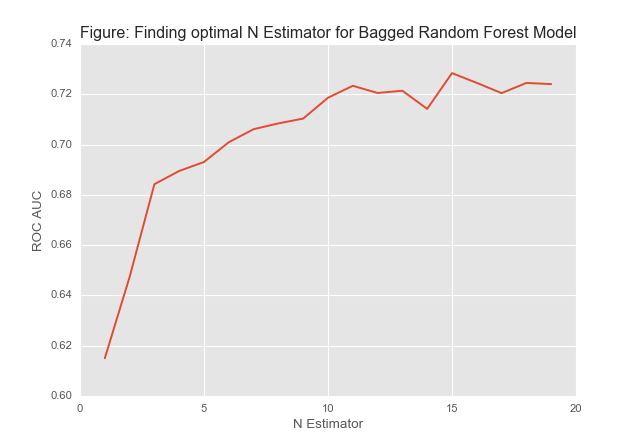

In [72]:
import matplotlib
%matplotlib nbagg
matplotlib.style.use('ggplot')

plt.plot(brf_range, brf_scores_roc)
plt.xlabel('N Estimator')
plt.ylabel('ROC AUC')
plt.title('Figure: Finding optimal N Estimator for Bagged Random Forest Model')

In [74]:
start = time.time()
brf = BaggingClassifier(n_estimators=15, random_state=42)
brf.fit(X, y)
brf_scores_acc = cross_val_score(brf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
brf = BaggingClassifier(n_estimators=15, random_state=42)
brf.fit(X, y)
brf_scores_roc = cross_val_score(brf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
end = time.time()
time_1_BRF = end - start
print "Accuracy of Bagged Random Forest Classification Method with optimized parameters : " + str(brf_scores_acc)
print "ROC AUC of Bagged Random Forest Classification Method with optimized parameters : " + str(brf_scores_roc)
print "Time: " +str(time_1_BRF)


Accuracy of Bagged Random Forest Classification Method with optimized parameters : 0.666666666667
ROC AUC of Bagged Random Forest Classification Method with optimized parameters : 0.729733383855
Time: 2.1628921032


### 13. Extreme Tree Classifier Model


In [75]:
start = time.time()
extree = ExtraTreesClassifier(random_state = 40, min_samples_split=1, bootstrap = True, max_depth = 7)
extree_scores_acc = cross_val_score(extree, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring = 'accuracy').mean()
extree_scores_roc = cross_val_score(extree, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring = 'roc_auc').mean()
end = time.time()
time_1_ExTree = end - start
print "Accuracy of Extra Tree Classification Method : " + str(extree_scores_acc)
print "ROC AUC of Extra Tree Classification Method : " + str(extree_scores_roc)
print "Time: " +str(time_1_ExTree)


Accuracy of Extra Tree Classification Method : 0.674666666667
ROC AUC of Extra Tree Classification Method : 0.736597386972
Time: 0.33794593811


### Comparison of the Methods

<IPython.core.display.Javascript object>


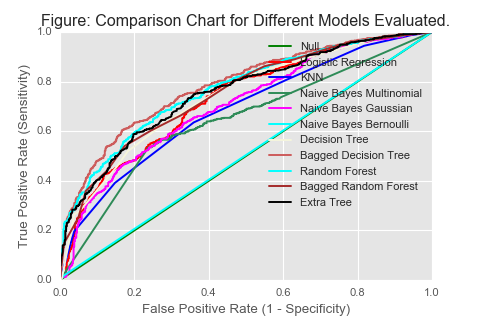

In [87]:
import matplotlib
%matplotlib nbagg
matplotlib.style.use('ggplot')

nullmodel_preds = nullmodel.predict_proba(X_test)[:,1]
nullmodel_fpr, nullmodel_tpr, _ = metrics.roc_curve(y_test, nullmodel_preds)

lreg.fit(X,y)
lreg_preds = lreg.predict_proba(X_test)[:,1]
lreg_fpr, lreg_tpr, _ = metrics.roc_curve(y_test, lreg_preds)

knn.fit(X,y)
knn_preds = knn.predict_proba(X_test)[:,1]
knn_fpr, knn_tpr, _ = metrics.roc_curve(y_test, knn_preds)

nbm.fit(X,y)
nbm_preds = nbm.predict_proba(X_test)[:,1]
nbm_fpr, nbm_tpr, _ = metrics.roc_curve(y_test, nbm_preds)

nbg.fit(X,y)
nbg_preds = nbg.predict_proba(X_test)[:,1]
nbg_fpr, nbg_tpr, _ = metrics.roc_curve(y_test, nbg_preds)

nbb.fit(X,y)
nbb_preds = nbb.predict_proba(X_test)[:,1]
nbb_fpr, nbb_tpr, _ = metrics.roc_curve(y_test, nbb_preds)

# The SVM Models did not complete execution
#svmpoly.fit(X,y)
#svmpoly_preds = svmpoly.predict_proba(X_test)[:,1]
#svmpoly_fpr, svmpoly_tpr, _ = metrics.roc_curve(y_test, svmpoly_preds)

#svmrbf.fit(X,y)
#svmpoly_preds = svmrbf.predict_proba(X_test)[:,1]
#svmrbf_fpr, svmrbf_tpr, _ = metrics.roc_curve(y_test, svmrbf_preds)

dtc.fit(X,y)
dtc_preds = dtc.predict_proba(X_test)[:,1]
dtc_fpr, dtc_tpr, _ = metrics.roc_curve(y_test, dtc_preds)

bag_cl_preds = bag_cl.predict_proba(X_test)[:,1]
bag_fpr, bag_tpr, _ = metrics.roc_curve(y_test, bag_cl_preds)

rfc_preds = rfc.predict_proba(X_test)[:,1]
rfc_fpr, rfc_tpr, _ = metrics.roc_curve(y_test, rfc_preds)

brf_preds = brf.predict_proba(X_test)[:,1]
brf_fpr, brf_tpr, _ = metrics.roc_curve(y_test, brf_preds)

extree.fit(X,y)
extree_preds = extree.predict_proba(X_test)[:,1]
extree_fpr, extree_tpr, _ = metrics.roc_curve(y_test, extree_preds)

plt.plot(nullmodel_fpr, nullmodel_tpr, label='Null', color='green') # Null Model
plt.plot(lreg_fpr, lreg_tpr, label='Logistic Regression', color='red') # Logistic Regression
plt.plot(knn_fpr, knn_tpr, label='KNN', color='blue') # kNN
plt.plot(nbm_fpr, nbm_tpr, label='Naive Bayes Multinomial', color='seagreen') # Naive Bayes - Multinomial
plt.plot(nbg_fpr, nbg_tpr, label='Naive Bayes Gaussian', color='magenta') # Naive Bayes - Gaussian
plt.plot(nbb_fpr, nbb_tpr, label='Naive Bayes Bernoulli', color='cyan') # Naive Bayes - Bernoulli
#plt.plot(svmpoly_fpr, svmpoly_tpr, label='SVM Polynomial', color='LimeGreen') # Naive Bayes - Bernoulli
#plt.plot(svmrbf_fpr, svmrbf_tpr, label='SVM Gaussian', color='CadmiumYellowLight') # Naive Bayes - Bernoulli
plt.plot(dtc_fpr, dtc_tpr, label='Decision Tree', color='Beige') # Decision Tree Classification
plt.plot(bag_fpr, bag_tpr, label='Bagged Decision Tree', color='indianred') # Bagged Decision Tree
plt.plot(rfc_fpr, rfc_tpr, label='Random Forest', color='Aqua') #Bagged Random Forest
plt.plot(brf_fpr, brf_tpr, label='Bagged Random Forest', color='brown') #Bagged Random Forest
plt.plot(extree_fpr, extree_tpr, label='Extra Tree', color='black') #Extra Tree


plt.legend()

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Figure: Comparison Chart for Different Models Evaluated.')

<IPython.core.display.Javascript object>


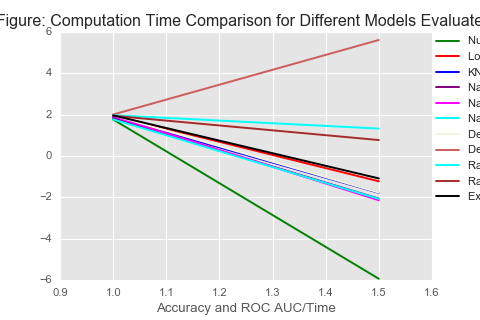

In [88]:
import matplotlib
%matplotlib nbagg
matplotlib.style.use('ggplot')

plt.plot([1, 1.5], [exp(null_score_acc), log(time_1_null)], label='Null Model', color='green')
plt.plot([1, 1.5], [exp(lreg_scores_acc), log(time_1_logreg)], label='Logistic Regression', color='red')
plt.plot([1, 1.5], [exp(knn_scores_acc), log(time_1_knn)], label='KNN', color='blue')
plt.plot([1, 1.5], [exp(nbm_scores_acc), log(time_1_nbm)], label='Naive Bayes - Multinomial', color='purple')
plt.plot([1, 1.5], [exp(nbg_scores_acc), log(time_1_nbg)], label='Naive Bayes - Gaussian', color='magenta')
plt.plot([1, 1.5], [exp(nbb_scores_acc), log(time_1_nbb)], label='Naive Bayes - Bernoulli', color='cyan')
plt.plot([1, 1.5], [exp(dtc_scores_acc), log(time_1_DTC_opt)], label='Decision Tree Classification', color='Beige')
plt.plot([1, 1.5], [exp(bag_scores_acc), log(time_1_BagDTC_opt)], label='Decision Tree Bagging', color='indianred')
plt.plot([1, 1.5], [exp(rf_scores_acc), log(time_1_rf)], label='Random Forest', color='Aqua')
plt.plot([1, 1.5], [exp(brf_scores_acc), log(time_1_BRF)], label='Random Forest Bagging', color='brown')
plt.plot([1, 1.5], [exp(extree_scores_acc), log(time_1_ExTree)], label='Extra Trees Classification', color='black')

pylab.xlim([0.9 , 1.6])
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.xlabel('Accuracy and ROC AUC/Time')
plt.title('Figure: Computation Time Comparison for Different Models Evaluated.')

### Conclusion
>From the two Figures above we see that Bagged Random Forest and Naive-Bayes Bernoulli models provides best ROC AUC.

>Regarding computation time, all the 3 Naive Bayes models perform better than the others.
>> Note: None of the two SVM methods could complete in 5 hours after which the executions were terminated.

